In [5]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [6]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi


In [7]:
target_angle=np.pi
angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*((self.u)**2)*(np.sin(self.th-np.pi/2)+1)/2
incorrectAngle_penalty = lambda self: -0.01*np.abs(self.th-target_angle)

reward_lambda = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self) # + incorrectAngle_penalty(self)
def reward_function(self):
    q=normalise_angle(self.th)
    if (abs(q)<=np.pi/4): return 15-5*(q+1)**2-0.1*self.omega**2
    else: return reward_lambda(self)


In [12]:

env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3., reward_fun=reward_function) 

# model = PPO('MlpPolicy', env, verbose=1) #b)
model = SAC('MlpPolicy', env, verbose=3, learning_starts=2000) #b)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [13]:
model.learn(total_timesteps=200_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | 17.4     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1313     |
|    time_elapsed    | 0        |
|    total_timesteps | 1200     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | 18.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 310      |
|    time_elapsed    | 7        |
|    total_timesteps | 2400     |
| train/             |          |
|    actor_loss      | -2.33    |
|    critic_loss     | 0.0114   |
|    ent_coef        | 0.887    |
|    ent_coef_loss   | -0.201   |
|    learning_rate   | 0.0003   |
|    n_updates       | 399      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

In [ ]:
model.save('SAC_working_save4')

In [ ]:
env.close()
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.,reward_fun=compute_reward,noise_scale=1e-3) 
render_sim = True
obs = env.reset()
u_list=[]
thetas=[]
omegas=[]
rewards=[]
try:
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if render_sim:
            env.render()
        u_list.append(action)
        thetas.append(obs[0])
        omegas.append(obs[1])
        rewards.append(reward)
        if render_sim:
            time.sleep(1/50)
        if done:
            obs=env.reset()
finally:
    env.close()

KeyboardInterrupt: 

In [ ]:
def get_color(q):
    if abs(q) > 2 * np.pi / 3:  # lower 120
        c=0
    elif abs(q) > np.pi / 3:  # either side
        c=1
    else:  # top
        c=2
    if abs(q)<=np.pi/4:
        c=3
    return c

def compute_reward_sim(self):
    q = normalise_angle(self.th)
    r=reward_function(self)
    c=get_color(q)
    return q, r, c

In [ ]:
@dataclass
class Data:
    th = None
    omega = None
    u = None

In [ ]:
if False:
    import json
    with open('SAC_irl_results.json') as f:
        results=json.load(f)
    u_list=results['u_list']
    omegas=results['omegas']
    thetas=results['thetas']
    rewards=results['rewards']

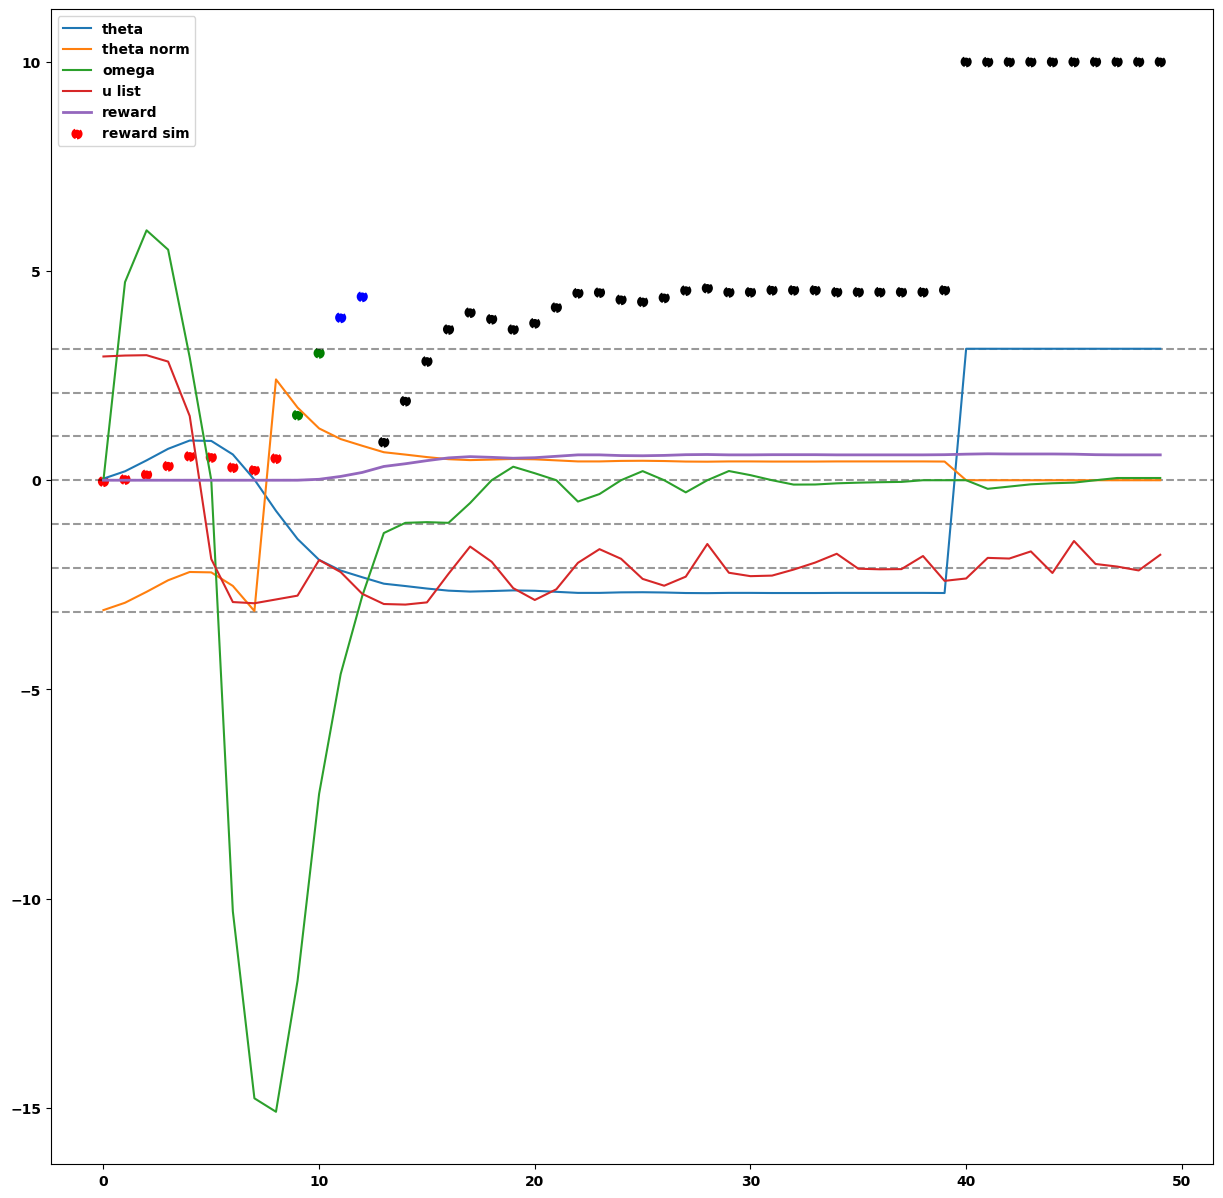

In [ ]:
rewards_sim=[]
colors=[]
thetas_norm=[]
colormap = np.array(['r', 'g', 'b'])
for i in range(len(u_list)):
    data=Data()
    data.th=thetas[i]
    data.omega=omegas[i]
    data.u=u_list[i]
    q, r,c = compute_reward_sim(data, )
    rewards_sim.append(r)
    colors.append(c)
    thetas_norm.append(q)

rewards_sim=np.array(rewards_sim)
rewards_sim=rewards_sim
colormap = np.array(['r', 'g', 'b', 'black'])


plot_start=0#np.argmax(rewards)
plot_end=plot_start+50

plt.figure(figsize=(15,15))
[plt.axhline(x, ls='--',c='black',alpha=0.4) for x in np.arange(-1,1.1,1/3)*np.pi]

plt.plot(thetas[plot_start:plot_end], label='theta')
plt.plot(thetas_norm[plot_start:plot_end], label='theta norm')
plt.plot(omegas[plot_start:plot_end], label='omega')
# plt.plot(np.array(omegas[:plot_end])**2, label='omega^2')
plt.plot(u_list[plot_start:plot_end], label='u list')
plt.plot(rewards[plot_start:plot_end], linewidth=2, label='reward')
plt.scatter([*range(len(u_list[plot_start:plot_end]))], rewards_sim[plot_start:plot_end], ls='--', linewidth=2, label='reward sim', c=colormap[colors[plot_start:plot_end]])
plt.legend()
plt.show()